# Introduction
This project describes how you can apply simple machine learning techniques to predict readmission for patients with diabetes.  The following Jupyter Notebook will take you through the process, highlighting rationales for the choices made to achieve high accuracy.

## Data Exploration

This analysis uses a publicly available dataset from UCI repository containing de-identified diabetes patient encounter data for 130 US hospitals (1999–2008) containing 101,766 observations over 10 years. 

### Key input variables (49): 
he dataset has over 50 features including patient characteristics, conditions, tests and 23 medications. Examples of these features are listed below:

Time in hospital (numeric)
Source of Admission (categorical)
Medication (categorical)
Discharge to (home, SNF, rehab)

### Output Variable:
Readmission <30 (days)

## Feature Engineering
## Building training/validation/test samples
model selection
model evaluation
Project Definition
Predict if a patient with diabetes will be readmitted to the hospital within 30 days.

## Data set exploration
The data that is used in this project originally comes from the UCI machine learning repository (https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008). The data consists of over 100000 hospital admissions from patients with diabetes from 130 US hospitals between 1999-2008.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pivottablejs import pivot_ui
import time
import streamlit as st

Load the data file

In [2]:
from pathlib import Path
import sqlite3
from sqlite3 import Connection

In [3]:
df = pd.read_csv("diabetic_data_initial.csv")

C:\Users\ehg\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#df['readmitted']=df['readmitted'].apply(lambda y: 1 if y == '<30' else 0)
df['weight'] = df['weight'].replace('?', " ")

In [5]:
df['medical_specialty'] = df['medical_specialty'].replace('?', "Unknown")

In [6]:
df.groupby(by='patient_nbr', sort=True)

In [7]:
for c in list(df.columns):
    
    # get a list of unique values
    n = df[c].unique()
    
    # if number of unique values is less than 30, print the values. Otherwise print the number of unique values
    if len(n)<30:
        print(c)
        print(n)
    else:
        print(c + ': ' +str(len(n)) + ' unique values')

encounter_id: 101766 unique values
patient_nbr: 71518 unique values
race
['Caucasian' 'AfricanAmerican' 'Other' '?' 'Hispanic' 'Asian']
gender
['Female' 'Male' 'Unknown/Invalid']
age
['[60-70)' '[50-60)' '[80-90)' '[30-40)' '[70-80)' '[40-50)' '[90-100)'
 '[20-30)' '[10-20)' '[0-10)']
weight
[' ' '[100-125)' '[75-100)' '[50-75)' '[0-25)' '[125-150)' '[25-50)'
 '[150-175)' '[175-200)' '>200']
admission_type_id
[3 1 2 6 5 8 4 7]
discharge_disposition_id
[ 1  6  3 11 14  8  4 22 18 23  2  7 28 25 13  5 19 24  9 27 15 17 16 12
 10 20]
admission_source_id
[ 1  7 17  4  6  9 20  2  5  8  3 14 10 11 22 25 13]
time_in_hospital
[ 7  4  5  8  3  1  2 11  9  6 10 13 12 14]
payer_code
['MC' 'BC' 'MD' '?' 'SP' 'OT' 'PO' 'CP' 'HM' 'DM' 'CM' 'OG' 'UN' 'MP' 'CH'
 'FR' 'SI' 'WC']
medical_specialty: 73 unique values
num_lab_procedures: 118 unique values
num_procedures
[1 3 0 2 4 5 6]
num_medications: 75 unique values
number_outpatient: 39 unique values
number_emergency: 33 unique values
number_inpatient

In [8]:
# dropping multiple encounters while keeping either first or last encounter of these patients
df2 = df.drop_duplicates(subset= ['patient_nbr'], keep = 'last')
df2.shape

(71518, 50)

In [9]:
df2=df2.drop(columns=['encounter_id', 'patient_nbr', 'diag_3'])

In [10]:
df2=df2.drop(columns=['acetohexamide', 'tolbutamide', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
                   'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'])

In [118]:
df2.head()

,weight,time_in_hospital,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,num_lab_procedures,number_diagnoses,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,payer_code,medical_specialty,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,glyburide-metformin,change,diabetesMed,readmitted,diag_t,diag_t2,admit_phys,discharge_to,payer,age_cat,OUTPUT_LABEL
1,unkown,4,3,10,0,0,0,86,9,Caucasian,Male,[50-60),urgent,home,er,BC,Unknown,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,>30,others,digestive,unkown,home,blu_x,50-70,0
5,unkown,3,0,6,0,0,0,71,6,Other,Female,[80-90),unknown,home,missing,?,Family/GeneralPractice,None,None,0,0,0,0,0,2,0,0,0,0,0,0,1,NO,others,metabolic_immunity,others,home,others,>70,0
6,unkown,5,2,14,0,0,0,54,9,Caucasian,Female,[70-80),urgent,home,er,?,InternalMedicine,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,NO,others,digestive,internal_med,home,others,>70,0
8,unkown,7,4,23,0,0,0,72,9,Caucasian,Male,[40-50),urgent,home,er,MC,Unknown,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,NO,others,respiratory,unkown,home,medicare,30-50,0
9,unkown,7,0,7,0,0,0,45,6,Caucasian,Female,[70-80),elective,home,referral,SP,Pulmonology,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,NO,others,metabolic_immunity,others,home,self,>70,0


In [12]:
cols = list(df.columns.values)
cols
df2 = df2.reindex(columns=['weight', 'time_in_hospital', 'num_procedures', 'num_medications', 'number_outpatient', 
                         'number_emergency', 'number_inpatient', 'num_lab_procedures', 'number_diagnoses', 
                         'race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
                         'payer_code', 'medical_specialty','diag_1', 'diag_2',  'max_glu_serum', 'A1Cresult', 'metformin',
                         'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 
                         'pioglitazone', 'rosiglitazone', 'insulin', 'glyburide-metformin', 'change', 'diabetesMed', 
                         'readmitted'])

# code age intervals [0-10) - [90-100) from 1-10
for i in range(0,10):
    df['age'] = df['age'].replace('['+str(10*i)+'-'+str(10*(i+1))+')', i+1)
# convert age back to integer type
df['age'] = df['age'].astype('int64')
print(df.age.value_counts())
# convert age categories to mid-point values
age_dict = {1:5, 2:15, 3:25, 4:35, 5:45, 6:55, 7:65, 8:75, 9:85, 10:95}
df['age'] = df.age.map(age_dict)
print(df.age.value_counts())

In [13]:
#pd.crosstab(index=df['readmitted'], columns=df['discharge_disposition_id']).apply(lambda r: r/r.sum(), axis=1)

In [14]:
print(type(df['diag_1']))

<class 'pandas.core.series.Series'>


In [15]:
df2['diag_t']=df2['diag_1'].replace(regex=['V'], value='10')
df2['diag_t']=df2['diag_t'].replace(regex=['E'], value='20')



In [16]:
df2['diag_t'] = df2['diag_t'].astype(float)

In [17]:
print(type(df2['diag_t']))

<class 'pandas.core.series.Series'>


In [18]:
df2['diag_t']=df2['diag_t'].apply(lambda diagnosis:"unknown" if diagnosis == 0 else 
    ("infectious" if diagnosis <140 else 
    ("neoplasms" if diagnosis <240 else 
    ("metabolic_immunity" if diagnosis <280 else 
    ("blood" if diagnosis <290 else 
    ("mental" if diagnosis < 320 else 
    ("nervous_sys" if diagnosis <390 else
    ("circulatory" if diagnosis <460 else
    ("respiratory" if diagnosis <520 else
    ("digestive" if diagnosis <580 else
    ("genitourinary" if diagnosis <630 else
    ("pregnancy" if diagnosis <680 else
    ("skin" if diagnosis <710 else
    ("musculoskeletal" if diagnosis <740 else
    ("congential" if diagnosis <760 else
    ("rare" if diagnosis <780 else
    ("ill-defined" if diagnosis <800 else
    ('injury_poison' if diagnosis <1000 else
    ("Sup" if diagnosis <1090 else
    ("sup_injury"))))))))))))))))))))

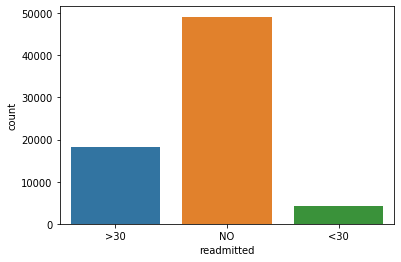

In [19]:
sns.countplot(df2['readmitted'])

In [20]:
df2['diag_t']=df2['diag_t'].apply(lambda diag: 'circulatory' if diag == 'circulatory' else
                                                  ('metabolic_immunity' if diag == 'metabolic_immunity' else
                                                   ('respiratory' if diag == 'respiratory' else
                                                    ('digestive' if diag == 'digestive' else
                                                    ('injury_poison' if diag == 'injury_poison' else 'others'))
                                                   )
                                                  )
                                                 )
                                                

In [21]:
df2[df2['readmitted'] == 'NO']

,weight,time_in_hospital,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,num_lab_procedures,number_diagnoses,race,...,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,glyburide-metformin,change,diabetesMed,readmitted,diag_t
5,,3,0,6,0,0,0,71,6,Other,...,Steady,No,No,No,No,No,No,Yes,NO,others
6,,5,2,14,0,0,0,54,9,Caucasian,...,No,No,No,No,No,No,No,No,NO,others
7,,3,3,32,0,0,0,45,7,Caucasian,...,No,No,No,No,No,No,No,Yes,NO,others
8,,7,4,23,0,0,0,72,9,Caucasian,...,No,No,No,No,No,No,No,No,NO,others
9,,7,0,7,0,0,0,45,6,Caucasian,...,No,No,No,No,No,No,No,No,NO,others
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,,3,0,11,0,0,0,65,8,Caucasian,...,No,No,Steady,No,Steady,No,Ch,Yes,NO,others
101762,,1,0,11,2,0,0,3,6,Caucasian,...,No,No,No,No,Steady,No,No,Yes,NO,others
101763,,1,0,10,0,0,0,44,5,AfricanAmerican,...,Steady,No,No,No,Steady,No,Ch,Yes,NO,others
101764,,1,4,7,0,0,0,29,9,Caucasian,...,No,No,Steady,No,No,No,No,Yes,NO,others


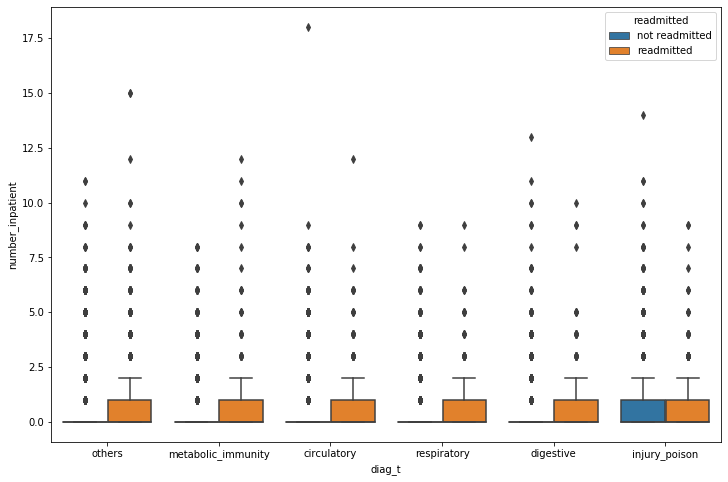

In [22]:
df_plot = df2.copy()
df_plot['readmitted']=df_plot['readmitted'].apply(lambda y: 'readmitted' if y == '<30' else 'not readmitted')
plt.figure(figsize=(12,8))
sns.boxplot(x='diag_t',y='number_inpatient',data=df_plot,hue='readmitted')

In [ ]:
df_plot['readmitted']=df_plot['readmitted'].apply(lambda y: 'readmitted' if y == '<30' else 'not readmitted')
plt.figure(figsize=(12,8))
sns.boxplot(x='diag_t',y='number_inpatient',data=df_plot,hue='readmitted')

In [198]:
df2

,weight,time_in_hospital,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,num_lab_procedures,number_diagnoses,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,payer_code,medical_specialty,diag_1,diag_2,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,glyburide-metformin,change,diabetesMed,readmitted,diag_t
1,,4,3,10,0,0,0,86,9,Caucasian,Male,[50-60),1,1,7,BC,Unknown,3,578,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,>30,others
5,,3,0,6,0,0,0,71,6,Other,Female,[80-90),6,1,17,?,Family/GeneralPractice,3,276,None,None,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO,others
6,,5,2,14,0,0,0,54,9,Caucasian,Female,[70-80),1,1,7,?,InternalMedicine,3,578,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,others
7,,3,3,32,0,0,0,45,7,Caucasian,Female,[60-70),2,11,4,?,Cardiology,3,785,None,None,Steady,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,others
8,,7,4,23,0,0,0,72,9,Caucasian,Male,[40-50),1,1,7,MC,Unknown,3,496,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,others
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,,3,0,11,0,0,0,65,8,Caucasian,Male,[70-80),1,7,7,CP,Unknown,V71,276,None,None,No,No,No,No,No,No,No,Steady,No,Steady,No,Ch,Yes,NO,others
101762,,1,0,11,2,0,0,3,6,Caucasian,Female,[40-50),3,1,1,MC,Hospitalist,V71,250.7,None,None,No,No,No,No,No,No,No,No,No,Steady,No,No,Yes,NO,others
101763,,1,0,10,0,0,0,44,5,AfricanAmerican,Male,[50-60),1,1,7,?,InternalMedicine,V71,401,None,None,Steady,No,No,No,No,Steady,No,No,No,Steady,No,Ch,Yes,NO,others
101764,,1,4,7,0,0,0,29,9,Caucasian,Female,[70-80),5,1,1,BC,Cardiology,V71,425,None,None,No,No,No,No,No,No,No,Steady,No,No,No,No,Yes,NO,others


In [199]:
#df['payer_code'].unique()

In [200]:
#sns.set(style="whitegrid")
#ax = sns.barplot(x="number_diagnoses", y= "diag_t", data=df)

In [23]:
df2['diag_t2']=df2['diag_2'].replace(regex=['V'], value='10')
df2['diag_t2']=df2['diag_t2'].replace(regex=['E'], value='20')

In [24]:
df2['diag_t2'] = df2['diag_t2'].astype(float)

In [25]:
df2['diag_t2']=df2['diag_t2'].apply(lambda diagnosis:"unknown" if diagnosis == 0 else 
    ("infectious" if diagnosis <140 else 
    ("neoplasms" if diagnosis <240 else 
    ("metabolic_immunity" if diagnosis <280 else 
    ("blood" if diagnosis <290 else 
    ("mental" if diagnosis < 320 else 
    ("nervous_sys" if diagnosis <390 else
    ("circulatory" if diagnosis <460 else
    ("respiratory" if diagnosis <520 else
    ("digestive" if diagnosis <580 else
    ("genitourinary" if diagnosis <630 else
    ("pregnancy" if diagnosis <680 else
    ("skin" if diagnosis <710 else
    ("musculoskeletal" if diagnosis <740 else
    ("congential" if diagnosis <760 else
    ("rare" if diagnosis <780 else
    ("ill-defined" if diagnosis <800 else
    ('injury_poison' if diagnosis <1000 else
    ("Sup" if diagnosis <1090 else
    ("sup_injury"))))))))))))))))))))

In [26]:
df2['diag_t2']=df2['diag_t2'].apply(lambda diag: 'circulatory' if diag == 'circulatory' else
                                                  ('metabolic_immunity' if diag == 'metabolic_immunity' else
                                                   ('respiratory' if diag == 'respiratory' else
                                                    ('digestive' if diag == 'digestive' else
                                                    ('genitourinary' if diag == 'genitourinary' else 'others'))
                                                   )
                                                  )
                                                 )
                                                

In [27]:
df2['admit_phys']=df2['medical_specialty'].apply(lambda specialty: "unkown" if specialty == 'Unknown' else
                                                 ('internal_med' if specialty == 'InternalMedicine' else
                                                  ('er' if specialty == 'Emergency/Trauma' else
                                                   ('family' if specialty == 'Family/GeneralPractic' else
                                                    ('cadio' if specialty == 'Cardiology' else
                                                    ('gen_surgery' if specialty == 'Surgery-General' else 'others'))
                                                   )
                                                  )
                                                 )
                                                )

In [206]:
#pd.crosstab(index=df['readmitted'], columns=df['time_in_hospital']).apply(lambda r: r/r.sum(), axis=1)

x, y, hue = "diag_t", "proportion", "readmitted"

(df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=y, y=x, hue=hue))

x, y, hue = "metformin", "proportion", "readmitted"

(df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue, ))
plt.tight_layout()

sns.distplot(df['time_in_hospital'],bins=14,kde=False,color='red')

In [28]:
df2['discharge_disposition_id'] = df2['discharge_disposition_id'].astype(str)

In [29]:
dict= {'1':'home', 
       '2':'short_hospital', 
       '3':'snf', 
       '4':'icf', 
       '5':'inpatient_inst',
       '6':'home_heal_serv', 
       '7':'ama',
       '8':'home_iv',
       '9':'now_inpatient',
       '10':'neonatal_aftercare',
       '11':'dead', 
       '12':'still_patient',
       '13':'hospice',
       '14':'medical_facility', 
       '15':'medicare_swing_bed',
       '16':'diff_outpatient',
       '17':'same_outpatient',
       '18':'NULL',
       '19':'dead',
       '20':'dead',
       '21':'dead',
       '22':'another_rehab',
       '23':'long_hospital',
       '24':'md_cert_nursing',
       '25':'unknown',
       '26':'unknown', 
       '30':'unknown',
       '27':'fed_facility',
       '28':'psychiatric',
       '29':'cah.'}
df2 =df2.replace({"discharge_disposition_id": dict})

In [30]:
df2['admission_type_id'] = df2['admission_type_id'].astype(str)

In [31]:
dict2={
    '1':'urgent',
    '2':'urgent',
    '3':'elective',
    '4':'elective',
    '5':'unknown',
    '6':'unknown',
    '7':'elective',
    '8':'Not Mapped',
}


In [32]:
df2 = df2.replace({"admission_type_id": dict2})

In [33]:
df2['admission_source_id'] = df2['admission_source_id'].astype(str)

In [34]:
dict3={
     '1':'referral',
     '2':'referral',
     '3':'referral',
     '4':'transfer',
     '5':'transfer',
     '6':'transfer',
     '7':'er',
     '8':'other',
     '9':'other',
     '10':'transfer',
     '11':'other',
     '12':'other',
     '13':'other',
     '14':'other',
     '15':'other',
     '17':'missing',
     '18':'other',
     '19':'other',
     '20':'other',
     '21':'other',
     '22':'other',
     '23':'other',
     '24':'other',
     '25':'other',
     '26':'other',  
    }
df2 = df2.replace({'admission_source_id': dict3})

In [35]:
df2['discharge_to']=df2['discharge_disposition_id'].apply(lambda loc: "home" if loc == 'home' else
                                                 ('snf' if loc == 'snf' else
                                                  ('home_health_serv' if loc == 'home_heal_serv' else
                                                   ('short_hospital' if loc == 'short_hospital' else
                                                    ('another_rehab' if loc == 'another_rehab' else
                                                    ('dead' if loc == 'dead' else
                                                    ('inpatient_inst' if loc == 'inpatient_inst' else 'others'))
                                                   )
                                                  )
                                                 )
                                                )
                                            )

In [36]:
df2 = df2[df2.discharge_to != 'dead']

In [37]:
df2['payer']=df2['payer_code'].apply(lambda pay:'medicare' if pay == 'MC'
                                  else ('health_maint_org' if pay == 'HM'
                                       else ('self' if pay == 'SP'
                                            else ('blu_x' if pay == 'BC'
                                                 else ('medicaid' if pay == 'MD'
                                                      else 'others')))))

In [38]:
df2['age_cat']=df2['age'].apply(lambda age:'0-30' if age == '[0-10)' 
                              else ('0-30' if age == '[10-20)' 
                                   else ('0-30' if age == '[20-30)'
                                        else('30-50' if age == '[30-40)'
                                             else ('30-50' if age == '[40-50)'
                                             else ('50-70' if age == '[50-60)'
                                                  else ('50-70' if age == '[50-70)'
                                                       else '>70'))
                                            )))))

In [39]:
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

In [40]:
df2['OUTPUT_LABEL'] = (df2.readmitted == '<30').astype('int')

In [41]:
print('Prevalence:%.3f'%calc_prevalence(df2['OUTPUT_LABEL'].values))

Prevalence:0.061


In [221]:
#df['readmitted']=df['readmitted'].apply(lambda y: 1 if y == '<30' else 0)

In [222]:
#sns.countplot(x='payer', data=df, hue='readmitted')

In [43]:
df2['age_cat'].unique()

array(['50-70', '>70', '30-50', '0-30'], dtype=object)

In [44]:
df['weight'].unique()

array([' ', '[100-125)', '[75-100)', '[50-75)', '[0-25)', '[125-150)',
       '[25-50)', '[150-175)', '[175-200)', '>200'], dtype=object)

In [45]:
pd.set_option('display.max_columns', 999)


In [46]:
df2=df2.drop(columns=['diag_1', 'diag_2'])

In [47]:
df.columns.get_loc("change")

47

In [48]:
df2['weight']= df2['weight'].replace({'>200':'>150','[175-200)':'>150','[150-175)':'>150','[50-75)':'75-150', 
                          '[75-100)':'75-150','[100-125)':'75-150','[125-150)':'75-150','[0-25)':'<50',
                           '[25-50)': '<50', ' ': 'unkown'})

In [49]:
df['weight'].unique()

array([' ', '[100-125)', '[75-100)', '[50-75)', '[0-25)', '[125-150)',
       '[25-50)', '[150-175)', '[175-200)', '>200'], dtype=object)

In [50]:
df2=df2.iloc[:,:].replace({'Up':3,'Steady':2,'Down':1,'No':0, 'Ch':1})

In [51]:
df2['diabetesMed']= df2['diabetesMed'].replace({'0':0, 'Yes':1})

In [52]:
df['diabetesMed'].unique()

array(['No', 'Yes'], dtype=object)

In [53]:
df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,117268386,23872788,Caucasian,Female,[60-70),,3,1,1,7,MC,InternalMedicine,45,1,24,0,0,0,3,785,276,8,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,>30
1,133884690,93890304,Caucasian,Male,[50-60),,1,1,7,4,BC,Unknown,86,3,10,0,0,0,3,578,283,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,>30
2,150319896,56569842,Caucasian,Male,[80-90),,1,6,7,4,MC,Unknown,54,0,17,0,0,0,3,276,427,9,None,None,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,>30
3,205293672,89910360,AfricanAmerican,Female,[30-40),,2,1,7,5,MD,Emergency/Trauma,71,2,8,0,1,0,3,780,564,9,None,Norm,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,>30
4,15245874,7436034,Caucasian,Female,[80-90),,1,3,1,8,?,InternalMedicine,47,0,11,0,0,1,3,276,276,8,None,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,195345552,60272127,Caucasian,Male,[70-80),,1,7,7,3,CP,Unknown,65,0,11,0,0,0,V71,276,250.02,8,None,None,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
101762,202781838,66029319,Caucasian,Female,[40-50),,3,1,1,1,MC,Hospitalist,3,0,11,2,0,0,V71,250.7,443,6,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO
101763,283973190,77442687,AfricanAmerican,Male,[50-60),,1,1,7,1,?,InternalMedicine,44,0,10,0,0,0,V71,401,250,5,None,None,Steady,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
101764,316141610,88172604,Caucasian,Female,[70-80),,5,1,1,1,BC,Cardiology,29,4,7,0,0,0,V71,425,424,9,None,None,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO


In [54]:
df3=pd.get_dummies(df2, columns=['weight', 'race', 'gender', 'admission_type_id',
                                 'admission_source_id', 'max_glu_serum', 'A1Cresult', 'readmitted', 'diag_t',
                                 'diag_t2', 'admit_phys', 'discharge_to', 'payer', 'age_cat'])

In [55]:
df3

,time_in_hospital,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,num_lab_procedures,number_diagnoses,age,discharge_disposition_id,payer_code,medical_specialty,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,glyburide-metformin,change,diabetesMed,OUTPUT_LABEL,weight_75-150,weight_<50,weight_>150,weight_unkown,race_?,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,gender_Unknown/Invalid,admission_type_id_Not Mapped,admission_type_id_elective,admission_type_id_unknown,admission_type_id_urgent,admission_source_id_er,admission_source_id_missing,admission_source_id_other,admission_source_id_referral,admission_source_id_transfer,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,readmitted_<30,readmitted_>30,readmitted_NO,diag_t_circulatory,diag_t_digestive,diag_t_injury_poison,diag_t_metabolic_immunity,diag_t_others,diag_t_respiratory,diag_t2_circulatory,diag_t2_digestive,diag_t2_genitourinary,diag_t2_metabolic_immunity,diag_t2_others,diag_t2_respiratory,admit_phys_cadio,admit_phys_er,admit_phys_gen_surgery,admit_phys_internal_med,admit_phys_others,admit_phys_unkown,discharge_to_another_rehab,discharge_to_home,discharge_to_home_health_serv,discharge_to_inpatient_inst,discharge_to_others,discharge_to_short_hospital,discharge_to_snf,payer_blu_x,payer_health_maint_org,payer_medicaid,payer_medicare,payer_others,payer_self,age_cat_0-30,age_cat_30-50,age_cat_50-70,age_cat_>70
1,4,3,10,0,0,0,86,9,[50-60),home,BC,Unknown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
5,3,0,6,0,0,0,71,6,[80-90),home,?,Family/GeneralPractice,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
6,5,2,14,0,0,0,54,9,[70-80),home,?,InternalMedicine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
8,7,4,23,0,0,0,72,9,[40-50),home,MC,Unknown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
9,7,0,7,0,0,0,45,6,[70-80),home,SP,Pulmonology,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,3,0,11,0,0,0,65,8,[70-80),ama,CP,Unknown,0,0,0,0,0,0,0,2,0,2,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
101762,1,0,11,2,0,0,3,6,[40-50),home,MC,Hospitalist,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
101763,1,0,10,0,0,0,44,5,[50-60),home,?,InternalMedicine,2,0,0,0,0,2,0,0,0,2,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
101764,1,4,7,0,0,0,29,9,[70-80),home,BC,Cardiology,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [56]:
df4= df3.drop(columns=['age','discharge_disposition_id', 'payer_code', 'medical_specialty', 'weight_unkown',
                        'race_?','race_Other','gender_Unknown/Invalid','admission_type_id_Not Mapped',
                        'admission_type_id_unknown', 'admission_source_id_missing', 'admission_source_id_other',
                        'max_glu_serum_None','A1Cresult_None',  'admit_phys_others', 'admit_phys_unkown',
                        'payer_others','readmitted_>30', 'readmitted_<30', 'readmitted_NO'])

In [57]:
df4 = df4.sample(n = len(df4), random_state = 42)
df4 = df4.reset_index(drop = True)

In [58]:
features = ['time_in_hospital',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'num_lab_procedures',
 'number_diagnoses','metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'glipizide',
 'glyburide',
 'pioglitazone',
 'rosiglitazone',
 'insulin',
 'glyburide-metformin',
 'change',
 'diabetesMed',
 'gender_Male',
 'admission_type_id_urgent',
 'admission_source_id_er',
 'admission_source_id_referral',
 'admission_source_id_transfer',
 'max_glu_serum_>200',
 'max_glu_serum_>300',
 'max_glu_serum_Norm',
 'A1Cresult_>7',
 'A1Cresult_>8',
 'A1Cresult_Norm',
 'diag_t_circulatory',
 'diag_t_digestive',
 'diag_t_metabolic_immunity',
 'diag_t_respiratory',
 'diag_t2_circulatory',
 'diag_t2_digestive',
 'diag_t2_genitourinary',
 'diag_t2_metabolic_immunity',
 'diag_t2_respiratory',
 'admit_phys_cadio',
 'admit_phys_er',
 'admit_phys_gen_surgery',
 'admit_phys_internal_med',
 'payer_blu_x',
 'payer_health_maint_org',
 'payer_medicaid',
 'payer_medicare',
 'payer_self', 'discharge_to_another_rehab', 'discharge_to_home',
 'discharge_to_home_health_serv',
 'discharge_to_inpatient_inst',
 'discharge_to_others',
 'discharge_to_short_hospital',
 'discharge_to_snf','age_cat_0-30', 'age_cat_30-50','age_cat_50-70','age_cat_>70']

 'discharge_to_another_rehab', 'discharge_to_home',
 'discharge_to_home_health_serv',
 'discharge_to_inpatient_inst',
 'discharge_to_others',
 'discharge_to_short_hospital',
 'discharge_to_snf','age_cat_0-30', 'age_cat_30-50','age_cat_50-70','age_cat_>70'

In [59]:
categorical = ['metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'glipizide',
 'glyburide',
 'pioglitazone',
 'rosiglitazone',
 'insulin',
 'glyburide-metformin',
 'change',
 'diabetesMed',
 'weight_75-150',
 'weight_<50',
 'weight_>150',
 'race_AfricanAmerican',
 'race_Asian',
 'race_Caucasian',
 'race_Hispanic',
 'gender_Female',
 'gender_Male',
 'admission_type_id_elective',
 'admission_type_id_urgent',
 'admission_source_id_er',
 'admission_source_id_referral',
 'admission_source_id_transfer',
 'max_glu_serum_>200',
 'max_glu_serum_>300',
 'max_glu_serum_Norm',
 'A1Cresult_>7',
 'A1Cresult_>8',
 'A1Cresult_Norm',
 'OUTPUT_LABEL',
 'diag_t_circulatory',
 'diag_t_digestive',
 'diag_t_injury_poison',
 'diag_t_metabolic_immunity',
 'diag_t_others',
 'diag_t_respiratory',
 'diag_t2_circulatory',
 'diag_t2_digestive',
 'diag_t2_genitourinary',
 'diag_t2_metabolic_immunity',
 'diag_t2_others',
 'diag_t2_respiratory',
 'admit_phys_cadio',
 'admit_phys_er',
 'admit_phys_gen_surgery',
 'admit_phys_internal_med',
 'discharge_to_another_rehab',
 'discharge_to_home',
 'discharge_to_home_health_serv',
 'discharge_to_inpatient_inst',
 'discharge_to_others',
 'discharge_to_short_hospital',
 'discharge_to_snf',
 'payer_blu_x',
 'payer_health_maint_org',
 'payer_medicaid',
 'payer_medicare',
 'payer_self', 'age_cat_0-30', 'age_cat_30-50','age_cat_50-70','age_cat_>70']

In [60]:
#df4[categorical]=df4[categorical].astype('object')

In [61]:
#def standardize(raw_data):
  #  return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

In [62]:
numerics = ['time_in_hospital',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'num_lab_procedures',
 'number_diagnoses']

In [63]:
numerics

['time_in_hospital',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'num_lab_procedures',
 'number_diagnoses']

In [64]:
df4[features].to_csv(r'C:\Users\ehg\Desktop\Hospital_readmission\cleaned.csv', index = False)

In [65]:
df4[numerics] = df4[numerics].astype('float')

In [66]:
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.light_palette((250, 100, 50), input="husl", n_colors=50).as_hex())
table = df4[numerics].corr(method='pearson')
table.style.background_gradient(cmap=my_cmap, axis = 0)

,time_in_hospital,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,num_lab_procedures,number_diagnoses
time_in_hospital,1.000000,0.174598,0.455465,-0.012841,-0.009875,0.085886,0.322681,0.228440
num_procedures,0.174598,1.000000,0.390717,-0.018628,-0.038266,-0.043338,0.039992,0.074880
num_medications,0.455465,0.390717,1.000000,0.036927,0.008234,0.051964,0.252527,0.258720
number_outpatient,-0.012841,-0.018628,0.036927,1.000000,0.101948,0.090806,-0.012403,0.089646
number_emergency,-0.009875,-0.038266,0.008234,0.101948,1.000000,0.186823,0.013151,0.059426
number_inpatient,0.085886,-0.043338,0.051964,0.090806,0.186823,1.000000,0.048618,0.099113
num_lab_procedures,0.322681,0.039992,0.252527,-0.012403,0.013151,0.048618,1.000000,0.153683
number_diagnoses,0.228440,0.074880,0.258720,0.089646,0.059426,0.099113,0.153683,1.000000


In [67]:
pd.options.display.max_rows = 400

c = df4[numerics].corr().abs()
s = c.unstack()
print(s.shape)
so = s.sort_values(ascending=False)

so[:]

(64,)


number_diagnoses    number_diagnoses      1.000000
num_lab_procedures  num_lab_procedures    1.000000
num_procedures      num_procedures        1.000000
num_medications     num_medications       1.000000
number_outpatient   number_outpatient     1.000000
number_emergency    number_emergency      1.000000
number_inpatient    number_inpatient      1.000000
time_in_hospital    time_in_hospital      1.000000
                    num_medications       0.455465
num_medications     time_in_hospital      0.455465
num_procedures      num_medications       0.390717
num_medications     num_procedures        0.390717
time_in_hospital    num_lab_procedures    0.322681
num_lab_procedures  time_in_hospital      0.322681
number_diagnoses    num_medications       0.258720
num_medications     number_diagnoses      0.258720
num_lab_procedures  num_medications       0.252527
num_medications     num_lab_procedures    0.252527
number_diagnoses    time_in_hospital      0.228440
time_in_hospital    number_diag

In [248]:
df4['number_diagnoses'].unique()

array([ 3.,  2.,  5.,  9.,  7.,  4.,  8.,  6., 11.,  1., 16., 13., 15.,
       12., 14., 10.])

In [249]:
#df4=pd.concat([df5,df4['readmitted_<30']],axis=1)

In [91]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df4[numerics])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [92]:
import pickle
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [93]:
scaler = pickle.load(open(scalerfile, 'rb'))

In [94]:
df4[numerics] = scaler.transform(df4[numerics])

In [95]:
df4[features]

,time_in_hospital,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,num_lab_procedures,number_diagnoses,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,glyburide-metformin,change,diabetesMed,gender_Male,admission_type_id_urgent,admission_source_id_er,admission_source_id_referral,admission_source_id_transfer,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_Norm,diag_t_circulatory,diag_t_digestive,diag_t_metabolic_immunity,diag_t_respiratory,diag_t2_circulatory,diag_t2_digestive,diag_t2_genitourinary,diag_t2_metabolic_immunity,diag_t2_respiratory,admit_phys_cadio,admit_phys_er,admit_phys_gen_surgery,admit_phys_internal_med,payer_blu_x,payer_health_maint_org,payer_medicaid,payer_medicare,payer_self,discharge_to_another_rehab,discharge_to_home,discharge_to_home_health_serv,discharge_to_inpatient_inst,discharge_to_others,discharge_to_short_hospital,discharge_to_snf,age_cat_0-30,age_cat_30-50,age_cat_50-70,age_cat_>70
0,1.255920,0.943078,0.282542,-0.278083,-0.212352,-0.422810,1.223516,-2.159521,2,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,-0.096405,-0.804596,-1.065270,-0.278083,-0.212352,-0.422810,-0.548580,-2.663517,0,0,0,0,0,0,2,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,-0.772567,1.525635,0.405070,-0.278083,-0.212352,-0.422810,1.274147,-1.151529,0,0,0,0,0,0,0,0,0,2,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,-0.096405,-0.222038,-0.330100,-0.278083,-0.212352,-0.422810,0.464046,-1.151529,0,0,0,0,0,0,2,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
4,-1.110648,-0.804596,0.772655,-0.278083,-0.212352,-0.422810,0.413415,0.864456,0,0,0,0,0,0,0,0,0,3,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70210,-0.096405,-0.804596,-0.820213,-0.278083,-0.212352,-0.422810,0.362784,-1.151529,0,0,0,0,0,0,0,0,0,2,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
70211,1.255920,0.360520,1.507825,-0.278083,-0.212352,-0.422810,-0.042267,-0.647532,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
70212,0.917839,1.525635,1.140240,-0.278083,-0.212352,-0.422810,-0.092898,0.864456,0,0,0,0,0,0,0,0,0,2,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
70213,2.270163,-0.222038,0.405070,-0.278083,-0.212352,-0.422810,1.577935,0.864456,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


In [96]:
df6=pd.concat([df4[categorical],df4[numerics]], axis=1)

In [97]:
df6.head(10)

,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,glyburide-metformin,change,diabetesMed,weight_75-150,weight_<50,weight_>150,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,gender_Female,gender_Male,admission_type_id_elective,admission_type_id_urgent,admission_source_id_er,admission_source_id_referral,admission_source_id_transfer,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_Norm,OUTPUT_LABEL,diag_t_circulatory,diag_t_digestive,diag_t_injury_poison,diag_t_metabolic_immunity,diag_t_others,diag_t_respiratory,diag_t2_circulatory,diag_t2_digestive,diag_t2_genitourinary,diag_t2_metabolic_immunity,diag_t2_others,diag_t2_respiratory,admit_phys_cadio,admit_phys_er,admit_phys_gen_surgery,admit_phys_internal_med,discharge_to_another_rehab,discharge_to_home,discharge_to_home_health_serv,discharge_to_inpatient_inst,discharge_to_others,discharge_to_short_hospital,discharge_to_snf,payer_blu_x,payer_health_maint_org,payer_medicaid,payer_medicare,payer_self,age_cat_0-30,age_cat_30-50,age_cat_50-70,age_cat_>70,time_in_hospital,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,num_lab_procedures,number_diagnoses
0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1.255920,0.943078,0.282542,-0.278083,-0.212352,-0.422810,1.223516,-2.159521
1,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,-0.096405,-0.804596,-1.065270,-0.278083,-0.212352,-0.422810,-0.548580,-2.663517
2,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.772567,1.525635,0.405070,-0.278083,-0.212352,-0.422810,1.274147,-1.151529
3,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,-0.096405,-0.222038,-0.330100,-0.278083,-0.212352,-0.422810,0.464046,-1.151529
4,0,0,0,0,0,0,0,0,0,3,0,1,1,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,-1.110648,-0.804596,0.772655,-0.278083,-0.212352,-0.422810,0.413415,0.864456
5,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.772567,0.360520,0.037485,-0.278083,-0.212352,-0.422810,-1.054893,-0.143536
6,0,0,0,0,0,0,0,0,0,3,0,1,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.434486,-0.804596,0.405070,-0.278083,-0.212352,1.900981,1.831092,-1.151529
7,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.772567,-0.222038,-0.575156,-0.278083,-0.212352,-0.422810,0.160259,-0.143536
8,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1.110648,-0.804596,-0.452628,0.619481,-0.212352,-0.422810,-2.067519,-2.159521
9,0,0,0,0,2,0,0,0,0,2,0,1,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0.917839,0.360520,-1.310326,-0.278083,-0.212352,0.739086,-0.902999,-0.143536


plt.scatter('number_outpatient', 'number_emergency', data=df4)
plt.show()

In [98]:
#sns.pairplot(df4[numerics])

features_2=list(sorting.iloc[1:30,0])


features_2

In [156]:
train_input = df6[features]
train_input

,time_in_hospital,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,num_lab_procedures,number_diagnoses,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,glyburide-metformin,change,diabetesMed,gender_Male,admission_type_id_urgent,admission_source_id_er,admission_source_id_referral,admission_source_id_transfer,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_Norm,diag_t_circulatory,diag_t_digestive,diag_t_metabolic_immunity,diag_t_respiratory,diag_t2_circulatory,diag_t2_digestive,diag_t2_genitourinary,diag_t2_metabolic_immunity,diag_t2_respiratory,admit_phys_cadio,admit_phys_er,admit_phys_gen_surgery,admit_phys_internal_med,payer_blu_x,payer_health_maint_org,payer_medicaid,payer_medicare,payer_self,discharge_to_another_rehab,discharge_to_home,discharge_to_home_health_serv,discharge_to_inpatient_inst,discharge_to_others,discharge_to_short_hospital,discharge_to_snf,age_cat_0-30,age_cat_30-50,age_cat_50-70,age_cat_>70
0,1.255920,0.943078,0.282542,-0.278083,-0.212352,-0.422810,1.223516,-2.159521,2,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,-0.096405,-0.804596,-1.065270,-0.278083,-0.212352,-0.422810,-0.548580,-2.663517,0,0,0,0,0,0,2,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,-0.772567,1.525635,0.405070,-0.278083,-0.212352,-0.422810,1.274147,-1.151529,0,0,0,0,0,0,0,0,0,2,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,-0.096405,-0.222038,-0.330100,-0.278083,-0.212352,-0.422810,0.464046,-1.151529,0,0,0,0,0,0,2,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
4,-1.110648,-0.804596,0.772655,-0.278083,-0.212352,-0.422810,0.413415,0.864456,0,0,0,0,0,0,0,0,0,3,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70210,-0.096405,-0.804596,-0.820213,-0.278083,-0.212352,-0.422810,0.362784,-1.151529,0,0,0,0,0,0,0,0,0,2,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
70211,1.255920,0.360520,1.507825,-0.278083,-0.212352,-0.422810,-0.042267,-0.647532,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
70212,0.917839,1.525635,1.140240,-0.278083,-0.212352,-0.422810,-0.092898,0.864456,0,0,0,0,0,0,0,0,0,2,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
70213,2.270163,-0.222038,0.405070,-0.278083,-0.212352,-0.422810,1.577935,0.864456,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


In [100]:
a = set(features)


In [157]:
train_output = df4['OUTPUT_LABEL']

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


In [158]:
X_train, X_dev, Y_train, Y_dev = train_test_split(train_input, train_output, test_size=0.20, random_state=42)


In [104]:
Y_dev

27333    0
25116    0
36228    0
52545    0
61457    0
        ..
67717    0
58320    0
7487     1
53401    0
41493    0
Name: OUTPUT_LABEL, Length: 14043, dtype: int32

In [163]:
# Data balancing applied using SMOTE
from imblearn.over_sampling import SMOTE

from collections import Counter
print('Original dataset shape {}'.format(Counter(train_output)))
sm = SMOTE(random_state=20)
train_input_new, train_output_new = sm.fit_sample(train_input, train_output)
print('New dataset shape {}'.format(Counter(train_output_new)))

Original dataset shape Counter({0: 65966, 1: 4249})
New dataset shape Counter({0: 65966, 1: 65966})


In [106]:
train_input_new

,time_in_hospital,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,num_lab_procedures,number_diagnoses,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,glyburide-metformin,change,diabetesMed,gender_Male,admission_type_id_urgent,admission_source_id_er,admission_source_id_referral,admission_source_id_transfer,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_Norm,diag_t_circulatory,diag_t_digestive,diag_t_metabolic_immunity,diag_t_respiratory,diag_t2_circulatory,diag_t2_digestive,diag_t2_genitourinary,diag_t2_metabolic_immunity,diag_t2_respiratory,admit_phys_cadio,admit_phys_er,admit_phys_gen_surgery,admit_phys_internal_med,payer_blu_x,payer_health_maint_org,payer_medicaid,payer_medicare,payer_self,discharge_to_another_rehab,discharge_to_home,discharge_to_home_health_serv,discharge_to_inpatient_inst,discharge_to_others,discharge_to_short_hospital,discharge_to_snf,age_cat_0-30,age_cat_30-50,age_cat_50-70,age_cat_>70
0,1.255920,0.943078,0.282542,-0.278083,-0.212352,-0.422810,1.223516,-2.159521,2,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,-0.096405,-0.804596,-1.065270,-0.278083,-0.212352,-0.422810,-0.548580,-2.663517,0,0,0,0,0,0,2,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,-0.772567,1.525635,0.405070,-0.278083,-0.212352,-0.422810,1.274147,-1.151529,0,0,0,0,0,0,0,0,0,2,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,-0.096405,-0.222038,-0.330100,-0.278083,-0.212352,-0.422810,0.464046,-1.151529,0,0,0,0,0,0,2,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
4,-1.110648,-0.804596,0.772655,-0.278083,-0.212352,-0.422810,0.413415,0.864456,0,0,0,0,0,0,0,0,0,3,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131927,-0.444805,-0.786815,-0.571416,-0.278083,-0.212352,3.062876,0.510042,0.864456,0,0,0,0,0,0,0,0,0,2,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
131928,-0.105507,-0.229880,-0.513067,-0.278083,-0.212352,0.150317,-0.295423,-0.385358,2,0,0,0,0,2,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
131929,-0.772567,0.498268,0.830600,-0.278083,-0.212352,0.464350,0.704232,0.864456,0,0,0,0,0,0,0,2,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
131930,-1.015985,-0.804596,-0.467332,-0.278083,-0.212352,-0.097477,0.642269,0.864456,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [143]:
train_output_new.value_counts()

1    65966
0    65966
Name: OUTPUT_LABEL, dtype: int64

In [164]:
train_input_new = pd.DataFrame(train_input_new, columns = list(train_input.columns))

In [165]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
X_train, X_dev, Y_train, Y_dev = train_test_split(train_input_new, train_output_new, test_size=0.30, random_state=42)
logreg = LogisticRegression(C=206.913808111479, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
print("Cross Validation Score: {:.2%}".format(np.mean(cross_val_score(logreg, X_train, Y_train, cv=10))))
logreg.fit(X_train, Y_train)
print("Dev Set score: {:.2%}".format(logreg.score(X_dev, Y_dev)))

C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

Cross Validation Score: 84.62%
Dev Set score: 84.59%


C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [121]:
Y_dev_predict = logreg.predict(X_dev)
pd.Series(Y_dev).unique()

array([0, 1])

from sklearn.metrics import confusion_matrix
confusion_matrix(Y_dev, Y_dev_predict)

dfval = pd.DataFrame({'Y_dev':Y_dev.astype(int), 'Y_dev_predict':Y_dev_predict.astype(int)})
pd.crosstab(dfval['Y_dev'], dfval['Y_dev_predict'])

In [122]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
print("Accuracy is {0:.2f}".format(accuracy_score(Y_dev, Y_dev_predict)))
print("Precision is {0:.2f}".format(precision_score(Y_dev, Y_dev_predict)))
print("Recall is {0:.2f}".format(recall_score(Y_dev, Y_dev_predict)))
print("AUC is {0:.2f}".format(roc_auc_score(Y_dev, Y_dev_predict)))

accuracy_logreg = accuracy_score(Y_dev, Y_dev_predict)
precision_logreg = precision_score(Y_dev, Y_dev_predict)
recall_logreg = recall_score(Y_dev, Y_dev_predict)
auc_logreg = roc_auc_score(Y_dev, Y_dev_predict)

Accuracy is 0.86
Precision is 0.88
Recall is 0.83
AUC is 0.86


from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 150]
    }
]
# Create grid search object

clf = GridSearchCV(logreg, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
# Fit on data

best_clf = clf.fit(X_train, Y_train)
best_clf.best_estimator_


In [123]:
from sklearn.metrics import classification_report
print(classification_report(Y_dev, Y_dev_predict))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86     19848
           1       0.88      0.83      0.86     19732

    accuracy                           0.86     39580
   macro avg       0.86      0.86      0.86     39580
weighted avg       0.86      0.86      0.86     39580



In [551]:
#filename = 'LogReg_model2.sav'
#pickle.dump(logreg, open(filename, 'wb'))
 

In [127]:
from sklearn.metrics import confusion_matrix
con_ma=confusion_matrix(Y_dev, Y_dev_predict)
con_ma=pd.DataFrame(con_ma)

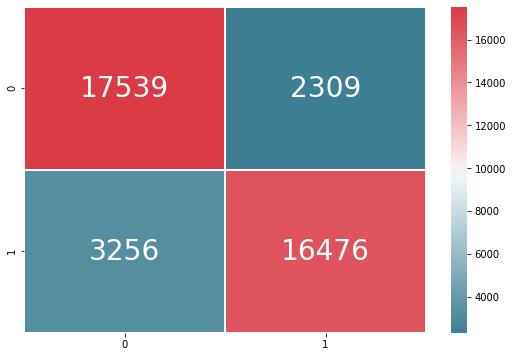

In [175]:
f, ax = plt.subplots(figsize=(9, 6))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(con_ma, annot=True, fmt="d", linewidths=1, ax=ax, cmap=colormap, annot_kws={'size':28})

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.933


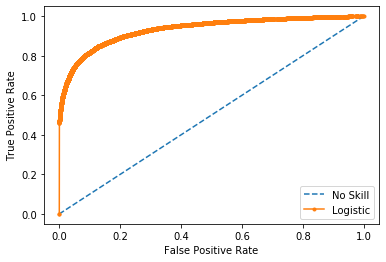

In [129]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

ns_probs = [0 for _ in range(len(Y_dev))]
# predict probabilities
lr_probs = logreg.predict_proba(X_dev)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(Y_dev, ns_probs)
lr_auc = roc_auc_score(Y_dev, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_dev, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_dev, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [116]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(Y_dev, Y_dev_predict))
print(rms)

0.3751368286670005


In [276]:
result = logreg.fit(X_train, Y_train)

C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [277]:
import statsmodels.api as sm
logit = sm.Logit(Y_train, X_train)
logit

In [278]:
from sklearn.metrics import r2_score
r2_score(Y_dev, Y_dev_predict)

0.4369835419776148

with open('LogReg', 'wb') as f:
    pickle.dump('logreg',f)

In [290]:
pd.set_option('display.max_rows', 100)

In [ ]:
logreg.

In [279]:
import statsmodels.api as sm
logit = sm.Logit(Y_train, X_train)

result = logit.fit()

# from scipy import stats
# stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

print(result.summary())
logit_coefs = pd.DataFrame(result.params)
logit_coefs.reset_index(inplace=True)
logit_coefs.columns = ["Feature", "Coefficient"]
logit_pvals = pd.DataFrame(result.pvalues)
logit_pvals.reset_index(inplace=True)
logit_pvals.columns = ["Feature", "pVal"]
logit_coefs['Absolute_Val']=abs(logit_coefs['Coefficient'])
logit_coefs = logit_coefs.merge(logit_pvals, how="inner", on=["Feature"])
logit_coefs = logit_coefs[logit_coefs.pVal <0.051]
something = logit_coefs.sort_values(by='Coefficient', ascending=False)


Optimization terminated successfully.
         Current function value: 0.472739
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           OUTPUT_LABEL   No. Observations:                92352
Model:                          Logit   Df Residuals:                    92291
Method:                           MLE   Df Model:                           60
Date:                Wed, 15 Jul 2020   Pseudo R-squ.:                  0.3180
Time:                        10:51:46   Log-Likelihood:                -43658.
converged:                       True   LL-Null:                       -64013.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
time_in_hospital                 -0.0211      0.011     -1.981      0.

In [394]:
something2 = something.loc[:,:]
#something2.to_csv(r'C:\Users\ehg\Desktop\Hospital_readmission\coeff2.csv', index = False)

In [116]:
#train_input_new.to_csv(r'C:\Users\ehg\Desktop\Hospital_readmission\cleaned2.csv', index = False)

In [169]:
sorting = logit_coefs.sort_values('Coefficient', ascending=False)
sorting

,Feature,Coefficient,Absolute_Val,pVal
20,diabetesMed,1.369943,1.369943,0.000000e+00
60,age_cat_>70,1.140507,1.140507,0.000000e+00
22,admission_type_id_urgent,0.454066,0.454066,8.674941e-87
23,admission_source_id_er,0.303971,0.303971,1.965602e-30
5,number_inpatient,0.288053,0.288053,1.672925e-303
6,num_lab_procedures,0.222585,0.222585,6.585899e-99
7,number_diagnoses,0.133571,0.133571,3.138374e-37
24,admission_source_id_referral,0.117759,0.117759,3.180760e-06
4,number_emergency,0.060186,0.060186,1.053734e-12
2,num_medications,0.036557,0.036557,2.466283e-03


# sklearn modules for preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# from imblearn.over_sampling import SMOTE  # SMOTE
# sklearn modules for ML model selection
from sklearn.model_selection import train_test_split  # import 'train_test_split'
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Libraries for data modelling
from sklearn import svm, tree, linear_model, neighbors
from sklearn import naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Common sklearn Model Helpers
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
# from sklearn.datasets import make_classification

# sklearn modules for performance metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve, recall_score, log_loss
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import average_precision_score

# selection of algorithms to consider and set performance measure
models = []
models.append(('Logistic Regression', LogisticRegression(solver='liblinear',
                                                         class_weight='balanced')))
models.append(('Random Forest', RandomForestClassifier(
    n_estimators=100,)))
#models.append(('SVM', SVC(gamma='auto')))
#models.append(('KNN', KNeighborsClassifier()))

#models.append(('Gaussian NB', GaussianNB()))

acc_results = []
auc_results = []
names = []
# set table to table to populate with performance results
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 
       'Accuracy Mean', 'Accuracy STD']
df_results = pd.DataFrame(columns=col)
i = 0
# evaluate each model using cross-validation
for name, model in models:
    print(i)
    kfold = model_selection.KFold(
        n_splits=5)  # 5-fold cross-validation

    cv_acc_results = model_selection.cross_val_score(  # accuracy scoring
        model, X_train, Y_train, cv=kfold, scoring='accuracy')

    cv_auc_results = model_selection.cross_val_score(  # roc_auc scoring
        model, X_train, Y_train, cv=kfold, scoring='roc_auc')

    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    names.append(name)
    df_results.loc[i] = [name,
                         round(cv_auc_results.mean()*100, 2),
                         round(cv_auc_results.std()*100, 2),
                         round(cv_acc_results.mean()*100, 2),
                         round(cv_acc_results.std()*100, 2)
                         ]
    i += 1
df_results.sort_values(by=['ROC AUC Mean'], ascending=False)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].set_title('Algorithm Accuracy Comparison', fontsize=16)
ax[0].boxplot(acc_results)
ax[0].set_xticklabels(names, fontsize=14)
ax[0].set_ylabel('Accuracy', fontsize=14)

ax[1].set_title('Algorithm ROC AUC Comparison', fontsize=16)
ax[1].boxplot(auc_results)
ax[1].set_xticklabels(names, fontsize=14)
ax[1].set_ylabel('ROC', fontsize=14)
fig.autofmt_xdate(rotation=45)
plt.show()

In [130]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [145]:
rfc = LogisticRegression(random_state=101)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(X_train, Y_train)

print('Optimal number of features: {}'.format(rfecv.n_features_))

C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

Optimal number of features: 59


C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


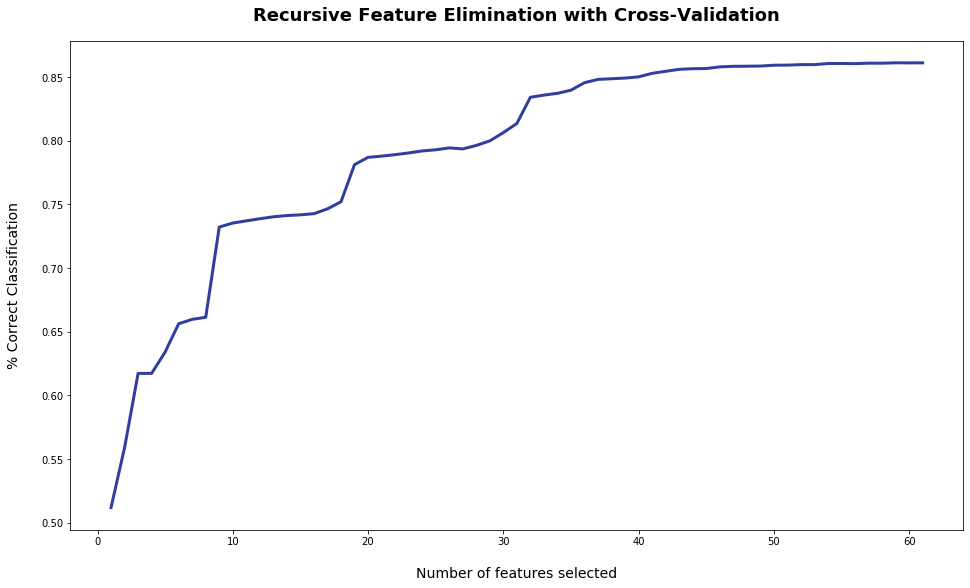

In [146]:

plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [147]:
feature_importance = list(zip(X_train, rfecv.support_))
new_features = []
for key,value in enumerate(feature_importance):
    if(value[1]) == True:
        new_features.append(value[0])
        
print(new_features)

['time_in_hospital', 'num_procedures', 'num_medications', 'number_outpatient', 'number_inpatient', 'num_lab_procedures', 'number_diagnoses', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'glyburide-metformin', 'change', 'diabetesMed', 'gender_Male', 'admission_type_id_urgent', 'admission_source_id_er', 'admission_source_id_referral', 'admission_source_id_transfer', 'max_glu_serum_>200', 'max_glu_serum_>300', 'max_glu_serum_Norm', 'A1Cresult_>7', 'A1Cresult_>8', 'A1Cresult_Norm', 'diag_t_circulatory', 'diag_t_digestive', 'diag_t_metabolic_immunity', 'diag_t_respiratory', 'diag_t2_circulatory', 'diag_t2_digestive', 'diag_t2_genitourinary', 'diag_t2_metabolic_immunity', 'diag_t2_respiratory', 'admit_phys_cadio', 'admit_phys_er', 'admit_phys_gen_surgery', 'admit_phys_internal_med', 'payer_blu_x', 'payer_health_maint_org', 'payer_medicaid', 'payer_medicare', 'payer_self', 'discharge_to_another_rehab', '

In [ ]:
new_features.

In [166]:
X_train = df6[new_features]
X_train, X_dev, Y_train, Y_dev = train_test_split(train_input_new, train_output_new, test_size=0.30, random_state=42)
logreg = LogisticRegression(C=206.913808111479, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
print("Cross Validation Score: {:.2%}".format(np.mean(cross_val_score(logreg, X_train, Y_train, cv=10))))
logreg.fit(X_train, Y_train)
print("Dev Set score: {:.2%}".format(logreg.score(X_dev, Y_dev)))

C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

Cross Validation Score: 84.62%
Dev Set score: 84.59%


C:\Users\ehg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [174]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
print("Accuracy is {0:.2f}".format(accuracy_score(Y_dev, Y_dev_predict)))
print("Precision is {0:.2f}".format(precision_score(Y_dev, Y_dev_predict)))
print("Recall is {0:.2f}".format(recall_score(Y_dev, Y_dev_predict)))
print("AUC is {0:.2f}".format(roc_auc_score(Y_dev, Y_dev_predict)))

accuracy_logreg = accuracy_score(Y_dev, Y_dev_predict)
precision_logreg = precision_score(Y_dev, Y_dev_predict)
recall_logreg = recall_score(Y_dev, Y_dev_predict)
auc_logreg = roc_auc_score(Y_dev, Y_dev_predict)

Accuracy is 0.86
Precision is 0.88
Recall is 0.83
AUC is 0.86


In [168]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [171]:

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [172]:
y_train_preds = rf.predict_proba(X_train)[:,1]
y_valid_preds = rf.predict_proba(X_dev)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(Y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Random Forest
Training:


NameError: name 'y_train' is not defined